In [1]:
import os
import re
import _pickle as cPickle
from collections import OrderedDict, defaultdict, Counter

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

from data_structure import Instance

# configure

In [2]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('output_path', 'data/synthetic/instances.pkl', 'path of output data')

flags.DEFINE_integer('n_vocab', 900, 'size of vocab')
flags.DEFINE_integer('n_doc', 11000, 'num of doc')
flags.DEFINE_integer('doc_l', 100, 'size of vocab')

flags.DEFINE_string('f', '', 'kernel')

config = flags.FLAGS

# sample docs

In [3]:
def hierarchical_sbp(tree_sticks_topic, tree_sticks_branch):
    tree_prob_topic = {}
    rest_topics = {}

    # calculate topic probability and save
    stick_topic = tree_sticks_topic[0]
    tree_prob_topic[0] = stick_topic
    rest_topics[0] = 1.-stick_topic
    for parent_idx, child_idxs in tree_idxs.items():
        rest_topic = rest_topics[parent_idx]
        rest_branch = 1.
        for child_idx in child_idxs:
            # calculate topic probability
            if child_idx == child_idxs[-1]: # last child
                prob_branch = rest_branch # phi
            else:
                stick_branch = tree_sticks_branch[child_idx] # psi
                prob_branch = stick_branch * rest_branch # phi

            if not child_idx in tree_idxs: # leaf childs
                prob_topic = prob_branch * rest_topic # pi
            else:
                stick_topic = tree_sticks_topic[child_idx] # upsilon
                prob_topic = stick_topic * prob_branch * rest_topic # pi

            # save topic probability and update rest stick length
            tree_prob_topic[child_idx] = prob_topic
            rest_branch = (1.- stick_branch) * rest_branch
            rest_topics[child_idx] = (1.-stick_topic)*prob_branch * rest_topic
            
    return tree_prob_topic

In [4]:
def get_depth(parent_idx=0, tree_depth = None, depth=1):
        if tree_depth is None: tree_depth={0: depth}

        child_idxs = tree_idxs[parent_idx]
        depth +=1
        for child_idx in child_idxs:
            tree_depth[child_idx] = depth
            if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
        return tree_depth

In [5]:
tree_idxs = {0:[1, 2, 3], 
                      1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

bow_idxs = np.arange(config.n_vocab)

In [6]:
ones = np.ones(config.n_vocab//3)
zeros = np.zeros(config.n_vocab//3)
leaf_1 = np.concatenate([np.ones([config.n_vocab//90, config.n_vocab//90]), np.zeros([config.n_vocab//90, config.n_vocab//90]), np.zeros([config.n_vocab//90, config.n_vocab//90])], 1).flatten()
leaf_2 = np.concatenate([np.zeros([config.n_vocab//90, config.n_vocab//90]), np.ones([config.n_vocab//90, config.n_vocab//90]), np.zeros([config.n_vocab//90, config.n_vocab//90])], 1).flatten()
leaf_3 = np.concatenate([np.zeros([config.n_vocab//90, config.n_vocab//90]), np.zeros([config.n_vocab//90, config.n_vocab//90]), np.ones([config.n_vocab//90, config.n_vocab//90])], 1).flatten()
# leaf_1 = np.concatenate([np.ones(config.n_vocab//9), np.zeros(config.n_vocab//9), np.zeros(config.n_vocab//9)])
# leaf_2 = np.concatenate([np.zeros(config.n_vocab//9), np.ones(config.n_vocab//9), np.zeros(config.n_vocab//9)])
# leaf_3 = np.concatenate([np.zeros(config.n_vocab//9), np.zeros(config.n_vocab//9), np.ones(config.n_vocab//9)])

In [7]:
tree_topic_bow_raw = {
                0: np.ones(config.n_vocab, dtype=np.float32),
                1: np.concatenate([ones, zeros, zeros]).astype(np.float32),
                2: np.concatenate([zeros, ones, zeros]).astype(np.float32),
                3: np.concatenate([zeros, zeros, ones]).astype(np.float32),
                10: np.concatenate([leaf_1, zeros, zeros]).astype(np.float32),
                11: np.concatenate([leaf_2, zeros, zeros]).astype(np.float32),
                12: np.concatenate([leaf_3, zeros, zeros]).astype(np.float32),
                20: np.concatenate([zeros, leaf_1, zeros]).astype(np.float32),
                21: np.concatenate([zeros, leaf_2, zeros]).astype(np.float32),
                22: np.concatenate([zeros, leaf_3, zeros]).astype(np.float32),
                30: np.concatenate([zeros, zeros, leaf_1]).astype(np.float32),
                31: np.concatenate([zeros, zeros, leaf_2]).astype(np.float32),
                32: np.concatenate([zeros, zeros, leaf_3]).astype(np.float32),
}

tree_topic_bow = {topic_idx: topic_bow_raw/np.sum(topic_bow_raw) for topic_idx, topic_bow_raw in tree_topic_bow_raw.items()}
topic_bow = np.concatenate([tree_topic_bow[topic_idx][None, :] for topic_idx in topic_idxs], 0)

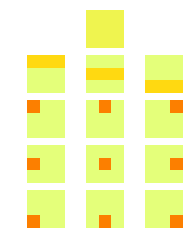

In [24]:
from matplotlib.colors import Normalize # Normalizeをimport

plt.figure(figsize=(3, 4))
plt.subplot(5,3,2)
plt.axis('off')
plt.imshow(topic_bow[0].reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(topic_bow)))

for i in range(1, len(topic_idxs)):
    plt.subplot(5,3,i+3)
    plt.axis('off')
    plt.imshow(topic_bow[i].reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(topic_bow)))

In [9]:
def hierarchical_sbp(tree_sticks_topic, tree_sticks_branch):
    tree_prob_topic = {}
    rest_topics = {}

    # calculate topic probability and save
    stick_topic = tree_sticks_topic[0]
    tree_prob_topic[0] = stick_topic
    rest_topics[0] = 1.-stick_topic
    for parent_idx, child_idxs in tree_idxs.items():
        rest_topic = rest_topics[parent_idx]
        rest_branch = 1.
        for child_idx in child_idxs:
            # calculate topic probability
            if child_idx == child_idxs[-1]: # last child
                prob_branch = rest_branch # phi
            else:
                stick_branch = tree_sticks_branch[child_idx] # psi
                prob_branch = stick_branch * rest_branch # phi

            if not child_idx in tree_idxs: # leaf childs
                prob_topic = prob_branch * rest_topic # pi
            else:
                stick_topic = tree_sticks_topic[child_idx] # upsilon
                prob_topic = stick_topic * prob_branch * rest_topic # pi

            # save topic probability and update rest stick length
            tree_prob_topic[child_idx] = prob_topic
            rest_branch = (1.- stick_branch) * rest_branch
            rest_topics[child_idx] = (1.-stick_topic)*prob_branch * rest_topic
            
    return tree_prob_topic

In [10]:
def get_depth(parent_idx=0, tree_depth = None, depth=1):
        if tree_depth is None: tree_depth={0: depth}

        child_idxs = tree_idxs[parent_idx]
        depth +=1
        for child_idx in child_idxs:
            tree_depth[child_idx] = depth
            if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
        return tree_depth

In [56]:
alp = 2.
lam = 1.
gam = 2.

In [58]:
instances = []

tree_depth = get_depth()

for idx_doc in range(config.n_doc):
    if idx_doc%1000 == 0: print(idx_doc)
    instance = Instance()
    instance.idx = idx_doc
    
    tree_sticks_topic = {}
    tree_sticks_branch = {}

    for topic_idx in topic_idxs:
        depth = tree_depth[topic_idx]
        tree_sticks_topic[topic_idx] = np.random.beta(1, alp*(lam**depth), 1)
        tree_sticks_branch[topic_idx] = np.random.beta(1, gam, 1)
        
    tree_prob_topic = hierarchical_sbp(tree_sticks_topic, tree_sticks_branch)
    prob_topic = np.concatenate([tree_prob_topic[topic_idx] for topic_idx in topic_idxs])
    prob_bow = prob_topic.dot(topic_bow)
    prob_bow /= np.sum(prob_bow)
    
    token_idxs = np.random.choice(config.n_vocab, config.doc_l, p=prob_bow)
    bow = np.array([Counter(token_idxs)[bow_idx] for bow_idx in bow_idxs])
    assert len(bow) == config.n_vocab
    instance.bow = bow
    
    instances.append(instance)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [59]:
prob_topics = []
for idx_doc in range(config.n_doc):
    tree_sticks_topic = {}
    tree_sticks_branch = {}

    for topic_idx in topic_idxs:
        depth = tree_depth[topic_idx]
        tree_sticks_topic[topic_idx] = np.random.beta(1, alp*(lam**depth), 1)
        tree_sticks_branch[topic_idx] = np.random.beta(1, gam, 1)
        
    tree_prob_topic = hierarchical_sbp(tree_sticks_topic, tree_sticks_branch)
    prob_topic = np.concatenate([tree_prob_topic[topic_idx] for topic_idx in topic_idxs])
    
    prob_topics.append(prob_topic)
    
np.mean(prob_topics, 0)

array([0.33149312, 0.07569248, 0.04940412, 0.09971497, 0.04938929,
       0.03254796, 0.06500881, 0.03231844, 0.02198462, 0.04401836,
       0.06573896, 0.04446812, 0.08822075])

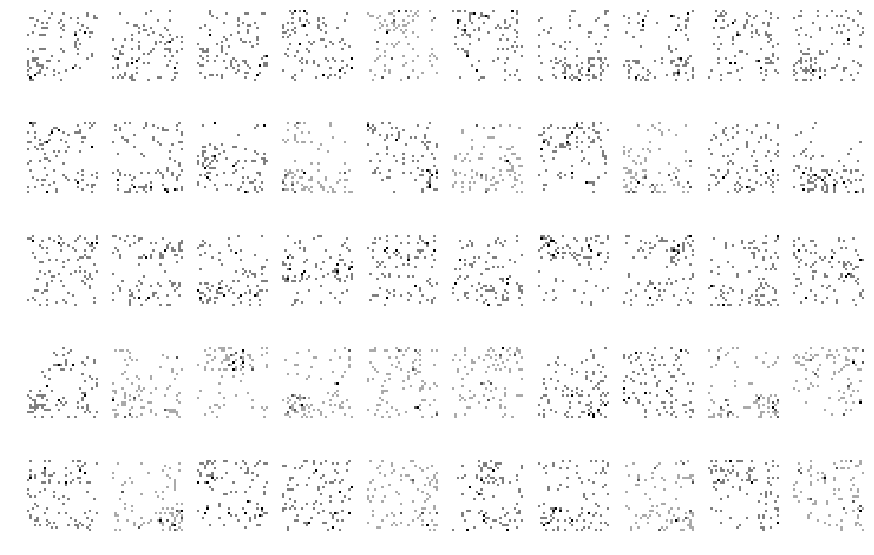

In [60]:
plt.figure(figsize=(15, 10))
for i, instance in enumerate(instances[:50]):
    plt.subplot(5,10,i+1)
    plt.axis('off')
    plt.imshow(instance.bow.reshape(int(config.n_vocab**(1/2)),int(config.n_vocab**(1/2))), cmap='gray_r')

# write out

In [61]:
instances_train = instances[:10000]
instances_valid = instances[10000:]
instances_test = instances_valid

In [62]:
idx_to_word = {bow_idx: str(10*(bow_idx//3+1) + bow_idx%3) for bow_idx in bow_idxs}
word_to_idx = {word: idx for idx, word in idx_to_word.items()}

In [63]:
print('saving preprocessed instances...')
cPickle.dump((instances_train, instances_valid, instances_test, word_to_idx, idx_to_word, bow_idxs),open(config.output_path,'wb'))

saving preprocessed instances...
